# Elastic horizontal free-surface

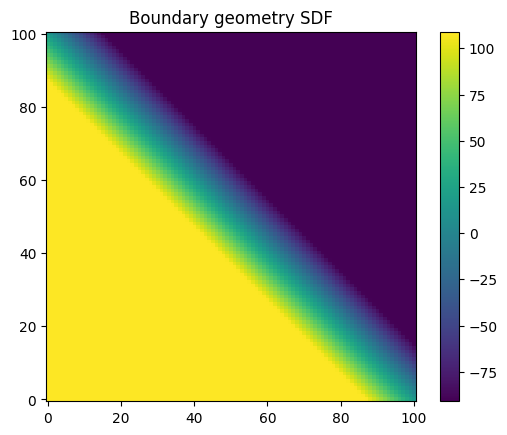

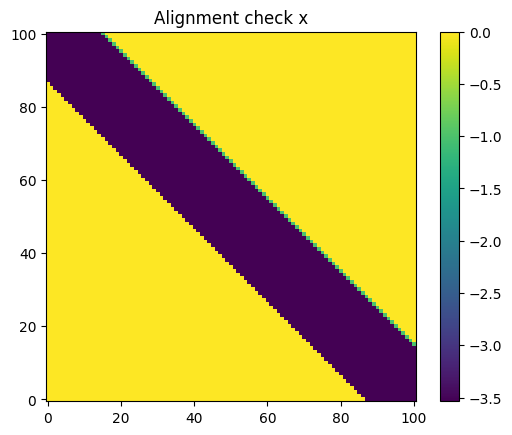

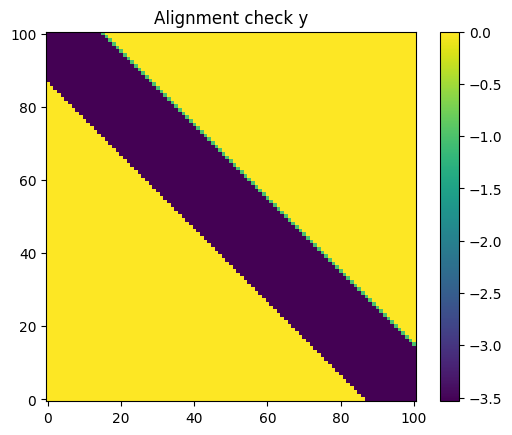

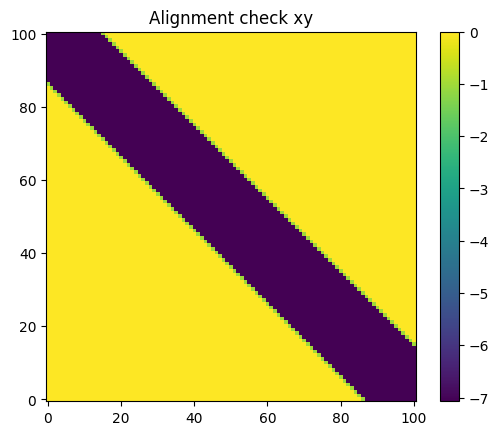

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt
import numpy as np

def read_sdf(surface):
    """Unpickle an sdf"""
    fname = 'sdfs/' + surface + '.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the horizontal 2D sdf
sdf = read_sdf('angled_surface_45_mirror_2d_node')

# Load the staggered sdfs
sdf_x = read_sdf('angled_surface_45_mirror_2d_x')
sdf_y = read_sdf('angled_surface_45_mirror_2d_y')
sdf_xy = read_sdf('angled_surface_45_mirror_2d_xy')

# Apply an offset to the sdf
sdf.data[:] += 9.
sdf_x.data[:] += 9.
sdf_y.data[:] += 9.
sdf_xy.data[:] += 9.

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

# It is a good idea to make sure your signed distance functions are aligned
# Misaligned SDFs can result in considerable weirdness
plt.imshow(sdf_x.data.T-sdf.data.T, origin='lower')
plt.title("Alignment check x")
plt.colorbar()
plt.show()

plt.imshow(sdf_y.data.T-sdf.data.T, origin='lower')
plt.title("Alignment check y")
plt.colorbar()
plt.show()

plt.imshow(sdf_xy.data.T-sdf.data.T, origin='lower')
plt.title("Alignment check xy")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry
import sympy as sp

x, y = sdf.grid.dimensions
h_x = x.spacing
h_y = y.spacing
zero = sp.core.numbers.Zero()
# Set cutoff for the velocity subgrids to zero
# This means that any velocity point on the interior can be updated
# This prevents over-extended extrapolations, as the velocity components do not have
# zeroth-order boundary conditions imposed upon them
# By default, this cutoff is 0.5 (half a grid spacing)
cutoff = {(h_x/2, zero): 0., (zero, h_y/2): 0.}

bg = BoundaryGeometry((sdf, sdf_x, sdf_y, sdf_xy), cutoff=cutoff)
grid = bg.grid  # Gets the grid from the signed distance function
print(tuple(bg.interior_mask.keys()))

Operator `normals` ran in 0.01 s


((0, 0), (h_x/2, 0), (0, h_y/2), (h_x/2, h_y/2))


We will want to define fields for particle velocity and the stress tensor. We will also define some material parameters used in the boundary conditions.

In [3]:
import devito as dv

s_o = 2
tau = dv.TensorTimeFunction(name='tau', grid=grid, space_order=s_o,
                            time_order=1)
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=s_o,
                          time_order=1)

# Material parameters
rho = 1.
mu = 0.25
lam = 0.5

Now to define the elastic free surface. This condition corresponds to the dot product of the stress tensor and the normal equalling zero.

In [4]:
from schism import BoundaryConditions

nx = bg.n[0]
ny = bg.n[1]

txx = tau[0, 0]
tyy = tau[1, 1]
txy = tau[0, 1]

vx = v[0]
vy = v[1]

bc_list = [dv.Eq(nx*txx + ny*txy, 0),  # Zeroth-order stress BCs
           dv.Eq(nx*txy + ny*tyy, 0),
           dv.Eq(ny*mu*txx.dxdy + nx*(lam+2*mu)*txx.dx2 + nx*(2*lam+2*mu)*txy.dxdy
                 + ny*mu*txy.dx2 + ny*mu*txy.dy2 + ny*mu*tyy.dxdy + nx*lam*tyy.dy2, 0),  # 2nd-order stress BCs
           dv.Eq(nx*mu*txx.dxdy + ny*lam*txx.dx2 + ny*(2*lam+2*mu)*txy.dxdy
                 + nx*mu*txy.dx2 + nx*mu*txy.dy2 + nx*mu*tyy.dxdy + ny*(lam+2*mu)*tyy.dy2, 0),
           dv.Eq(nx*(lam+2*mu)*vx.dx + nx*lam*vy.dy + ny*mu*vx.dy + ny*mu*vy.dx, 0),  # Velocity BCs
           dv.Eq(nx*mu*vx.dy + nx*mu*vy.dx + ny*(lam+2*mu)*vy.dy + ny*lam*vx.dx, 0)]

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

In [6]:
x, y = grid.dimensions
h_x = x.spacing
h_y = y.spacing

# TODO: check how this staggering is going to interact with Schism's internals
txxdx = tau[0, 0].dx(x0=x+h_x/2)
txydx = tau[0, 1].dx(x0=x)
vxdx = v[0].forward.dx(x0=x)
vydx = v[1].forward.dx(x0=x+h_x/2)

txydy = tau[0, 1].dy(x0=y)
tyydy = tau[1, 1].dy(x0=y+h_y/2)
vxdy = v[0].forward.dy(x0=y+h_y/2)
vydy = v[1].forward.dy(x0=y)

derivs = (txxdx, txydx, vxdx, vydx,
          txydy, tyydy, vxdy, vydy)

subs = boundary.substitutions(derivs)

Generating stencils for Derivative(tau_xx(t, x, y), x)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(tau_xy(t, x + h_x/2, y + h_y/2), x)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(v_x(t + dt, x + h_x/2, y), x)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(v_y(t + dt, x, y + h_y/2), x)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(tau_xy(t, x + h_x/2, y + h_y/2), y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(tau_yy(t, x, y), y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(v_x(t + dt, x + h_x/2, y), y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(v_y(t + dt, x, y + h_y/2), y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


In [7]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 550.  # Simulation last 0.5 seconds (500 ms)
dt = 0.5*5/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.006  # Source peak frequency is 16Hz (0.016 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 300.

In [8]:
# Various shorthands for clarity
b = 1/rho


# Velocity updates
eq_vx = dv.Eq(v[0].forward, v[0] + dt*b*(subs[txxdx] + subs[txydy]))
eq_vy = dv.Eq(v[1].forward, v[1] + dt*b*(subs[txydx] + subs[tyydy]))

# Normal stress updates
eq_txx = dv.Eq(tau[0, 0].forward, tau[0, 0] + dt*(lam+2*mu)*subs[vxdx] + dt*lam*subs[vydy])
eq_tyy = dv.Eq(tau[1, 1].forward, tau[1, 1] + dt*(lam+2*mu)*subs[vydy] + dt*lam*subs[vxdx])

# Shear stress update
eq_txy = dv.Eq(tau[0, 1].forward, tau[0, 1] + dt*mu*(subs[vxdy] + subs[vydx]))

In [9]:
src_txx = src.inject(field=tau[0, 0].forward, expr=src)
src_tyy = src.inject(field=tau[1, 1].forward, expr=src)

In [10]:
op = dv.Operator([eq_vx, eq_vy, eq_txx, eq_tyy, eq_txy] + src_txx + src_tyy)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.55 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.5472509999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00013499999999999973, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

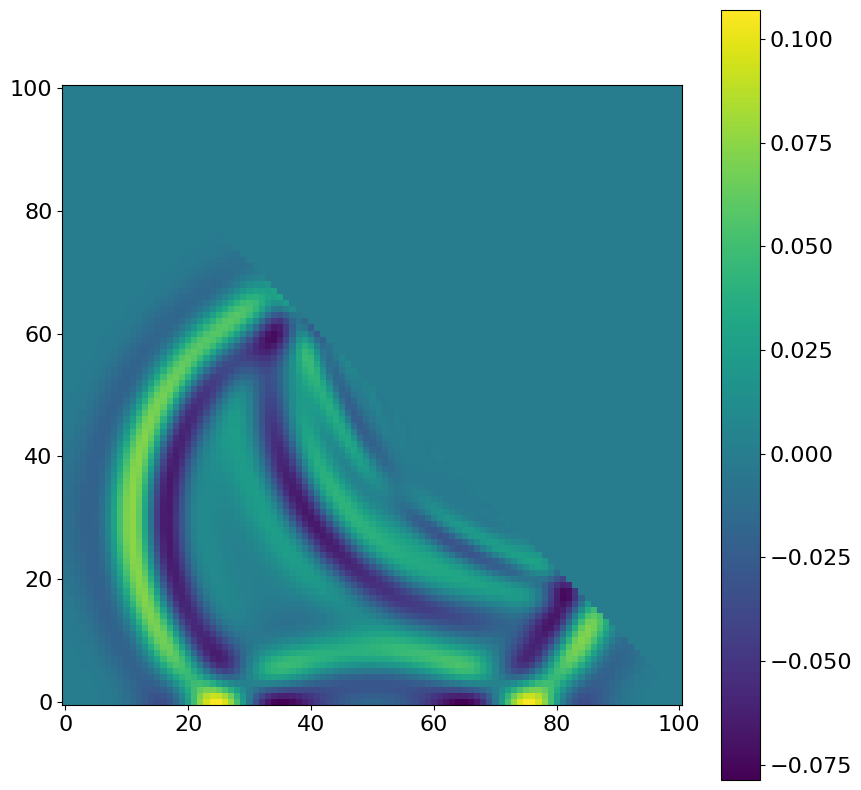

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(tau[0, 0].data[1].T, origin='lower')
plt.colorbar()
plt.show()

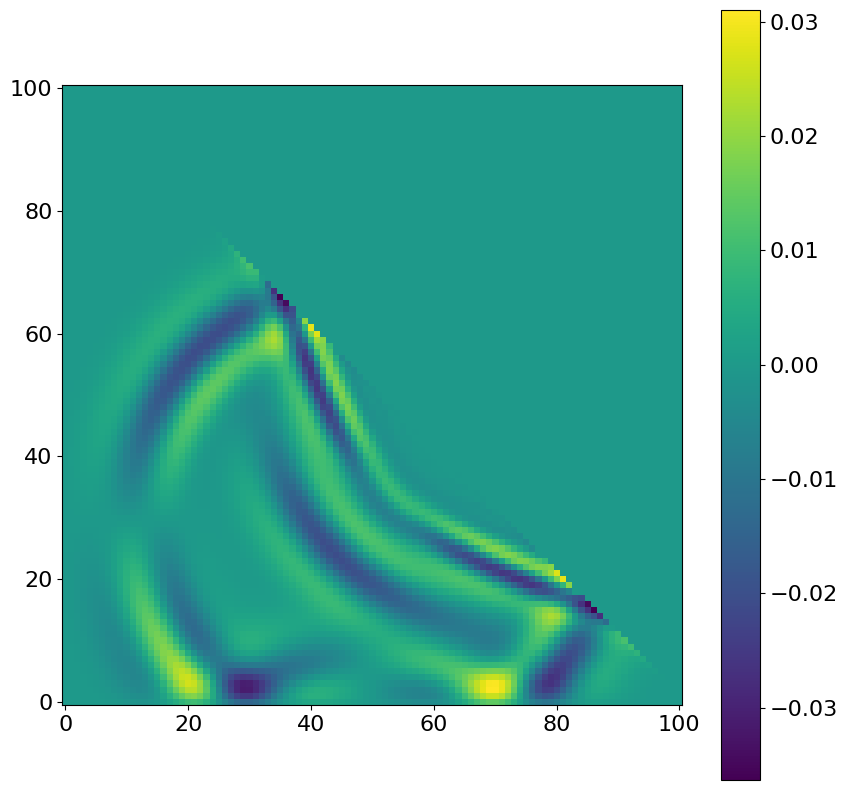

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(tau[0, 1].data[1].T, origin='lower')
plt.colorbar()
plt.show()

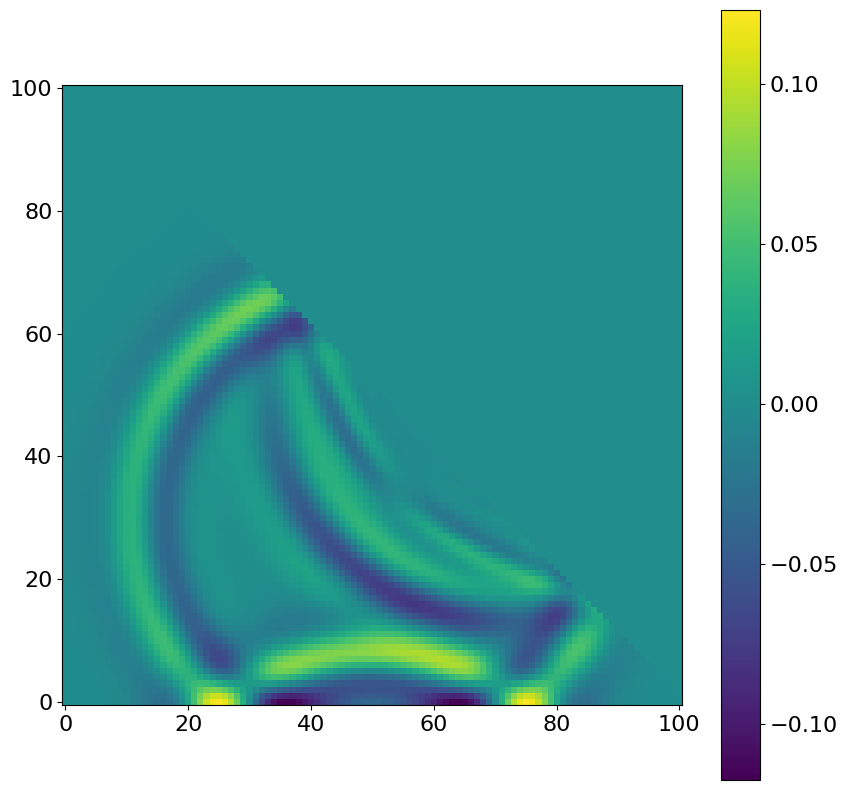

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(tau[1, 1].data[1].T, origin='lower')
plt.colorbar()
plt.show()

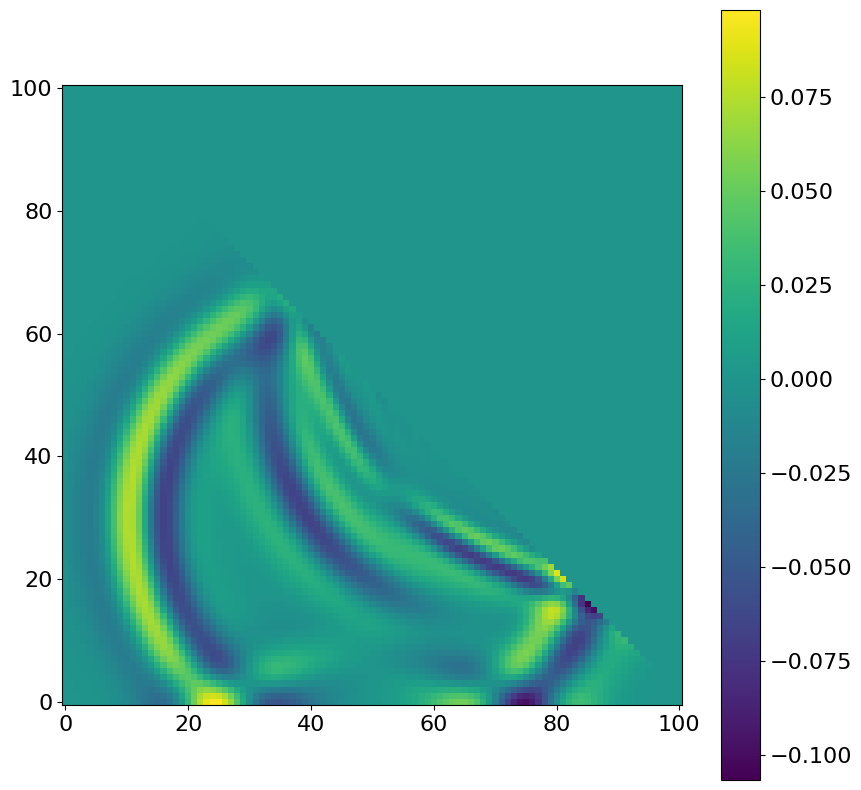

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(v[0].data[1].T, origin='lower')
plt.colorbar()
plt.show()

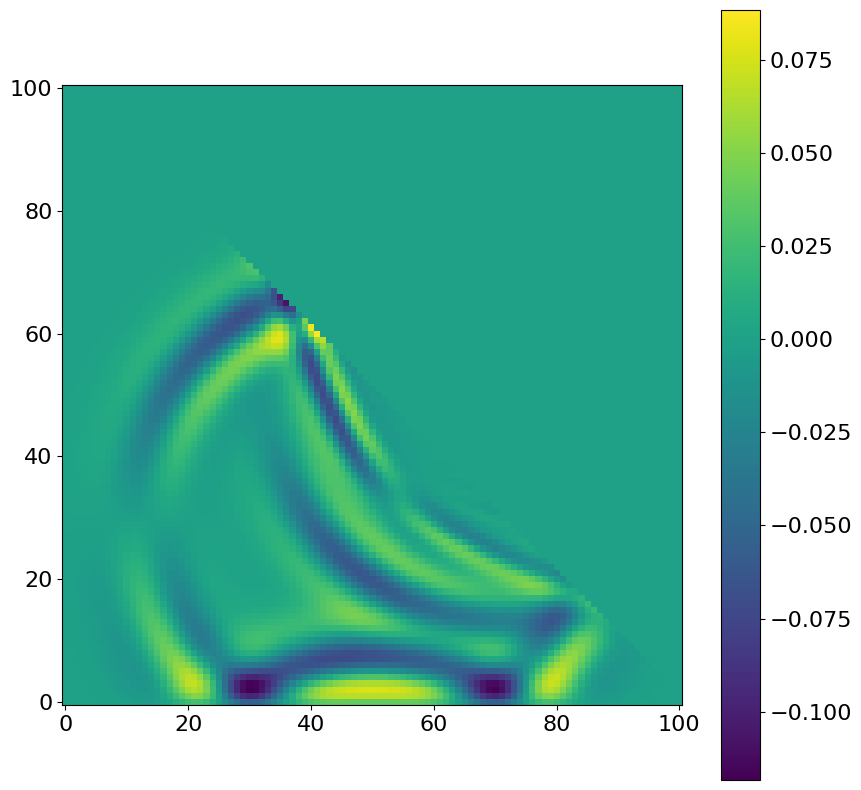

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(v[1].data[1].T, origin='lower')
plt.colorbar()
plt.show()

Note that the reflection off the immersed boundary results in a PS conversion, which is not seen when the wave hits the bottom of the domain.